# Classification

## Dowloading MNIST Dataset

In [1]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [2]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

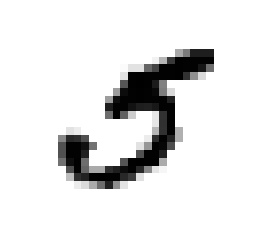

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [5]:
y[36000]

5.0

## Train set & Test set

In [6]:
# This dataset is split in training set (60000) and test set (10000)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Shuffle data
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Binary Classifier

In [7]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [9]:
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

## Performance Measures

### Measuring Accuracy using Cross-Validation

In [10]:
# Defining my own cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.96405
0.8511
0.87075


In [11]:
# Now using cros_val_score
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([ 0.96405,  0.8511 ,  0.87075])

In [12]:
# Demostrating accuracy is not a good scoring measure
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")
# Above 90% because 10% of the datasets has 5s,so mosy of the time guess no 5s

array([ 0.9095 ,  0.91005,  0.9094 ])

### Confusion Matrix

In [13]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [14]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[48892,  5687],
       [  595,  4826]])

In [15]:
TN,FP,FN,TP = cm[0,0], cm[0,1], cm[1,0], cm[1,1] # True negative, False positive, False negative, True positive

**Precision:** accuracy of the positive predictions

$ precision = \frac{TP}{TP +TF} $

In [16]:
precision = TP/(TP+FP)
precision

0.45905069913440505

**Recall (sensitivity or true positive rate (TPR)):** ratio of positive instances that are correctly detected by the classifier

$recall = \frac{TP}{TP+FN}$

In [17]:
recall = TP/(TP+FN)
recall

0.89024165283158085

**Precision & Recall** from Sci-kit learn

In [18]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) ## Classifier is correct 63% of the time

0.45905069913440505

In [19]:
recall_score(y_train_5, y_train_pred) ## Classifier detects 85% of the 5s

0.89024165283158085

**$F_1$ score**: combine precision & recall, used to compare two classifiers. Use the harmonic mean because a differemce with normal mean, this one gives much more weight to low values. Then, result gets a high $F_1$ score if both precision & recall are high.

$F_1 = \frac{2}{\frac{1}{precision}+\frac{1}{recall}} = 2 * \frac{precision*recall}{precision+recall} = \frac{TP}{TP+\frac{FN+Fp}{2}}$

In [20]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.60574871344295222

**Precision & recall tradeoff**: increasing precision, reduces recall and vice versa.

In [21]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [22]:
from sklearn.metrics import  precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

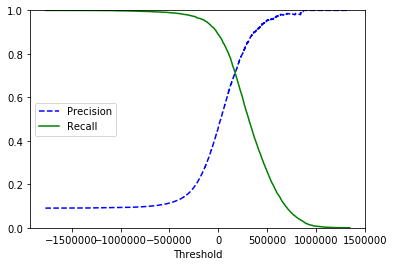

In [23]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

### The ROC CURVE

The receiver operating characteristic used with binary classifiers, the ROC curve plots _true positive rate_ (recall) against _false positive rate_

In [24]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

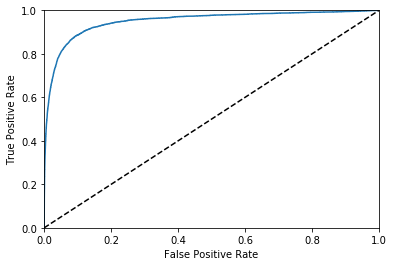

In [25]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr)

Perfect classifier an area under the curve (ROC AUC) = 1

In [26]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.95038464828727254

**Plotting ROC Curve with _RandomForestClassifier_**

In [27]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [28]:
y_score_forest = y_probas_forest[:,1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_score_forest)

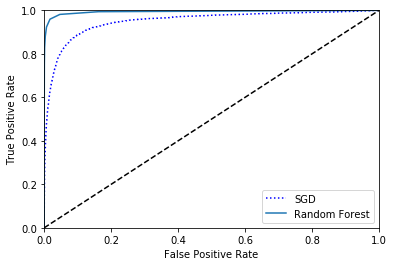

In [29]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [30]:
roc_auc_score(y_train_5, y_score_forest)

0.99352843429563586

In [31]:
from sklearn.model_selection import cross_val_predict
y_train_forest_pred = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_forest_pred)

0.98510078878177043

In [32]:
recall_score(y_train_5, y_train_forest_pred)

0.82936727541044086

### Multiclass classification

In [33]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([ 5.])

In [34]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[  64117.00021763, -524430.31818157, -162010.01559011,
        -145899.25046895, -192231.65345112,  131818.25363084,
        -625328.02964685, -330058.14070217, -672886.29776061,
        -546073.30552406]])

In [35]:
np.argmax(some_digit_scores)

5

In [36]:
sgd_clf.classes_

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [37]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([ 5.])

In [38]:
len(ovo_clf.estimators_)

45

In [39]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([ 5.])

In [40]:
forest_clf.predict_proba([some_digit])

array([[ 0. ,  0. ,  0. ,  0. ,  0. ,  0.9,  0. ,  0. ,  0. ,  0.1]])

In [41]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.86837632,  0.86619331,  0.86382957])

In [42]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([ 0.91346731,  0.90819541,  0.9079862 ])

### Error Analysis

In [45]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5741,    2,   18,    5,   11,   42,   45,    7,   46,    6],
       [   2, 6468,   46,   28,    6,   40,    6,   11,  124,   11],
       [  58,   42, 5311,  108,   85,   22,   89,   58,  166,   19],
       [  50,   41,  135, 5331,    2,  230,   34,   53,  148,  107],
       [  24,   25,   29,    8, 5366,   10,   54,   31,   80,  215],
       [  73,   42,   38,  187,   69, 4609,  105,   25,  187,   86],
       [  40,   22,   45,    1,   49,   90, 5613,    8,   49,    1],
       [  27,   23,   67,   26,   55,   10,    7, 5788,   16,  246],
       [  46,  144,   60,  148,   11,  149,   53,   26, 5067,  147],
       [  41,   32,   21,   87,  153,   38,    2,  197,   79, 5299]])

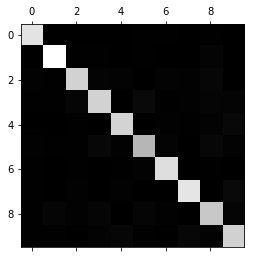

In [47]:
## Image representation of plot matrix
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

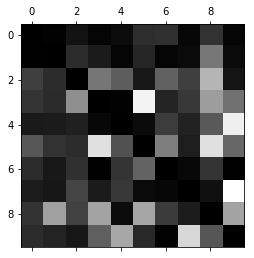

In [48]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()